## Term paper Medical image analysis

In [1]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras import backend as K
import cv2
import shutil
import glob
import imutils
import warnings
warnings.filterwarnings('ignore')


In [2]:
# gaussian ,median ,dilation ,erosion ,clhe, HE 

### preprocessing functions

In [3]:
from skimage.morphology import square
from skimage.util import img_as_ubyte
from skimage.morphology import (erosion, dilation, opening, closing,white_tophat)
from skimage.morphology import disk 
from skimage.filters import gaussian,median
from skimage import exposure

#### clahe

In [4]:
def clahe(src_img):
    (B1, G1, R1) = cv2.split(src_img)
    bgr = []
    for i in (B1, G1, R1):
        equ_img = exposure.equalize_adapthist(i*(1.0/255.0), kernel_size=None, clip_limit=0.01, nbins=256)*255
        bgr.append(equ_img)
    merged = cv2.merge(bgr)
    return merged

#### dilation

In [5]:
def dilation_(src_img):
    (B1, G1, R1) = cv2.split(src_img)
    bgr = []
    for i in (B1, G1, R1):
        equ_img = dilation(i,disk(3))
        bgr.append(equ_img)
    merged = cv2.merge(bgr)
    return merged

#### erosion

In [6]:
def erosion_(src_img):
    (B1, G1, R1) = cv2.split(src_img)
    bgr = []
    for i in (B1, G1, R1):
        equ_img = erosion(i)
        bgr.append(equ_img)
    merged = cv2.merge(bgr)
    return merged

#### Gaussian filter

In [7]:
def gaussian_filter(src_img):
    return gaussian(src_img)

#### Median filter

In [8]:
def median_filter(src_img):
    return median(src_img)

#### histogram equalization

In [9]:
def histogram_equalization(src_img):
    (B1, G1, R1) = cv2.split(src_img)
    bgr = []
    for i in (B1, G1, R1):
        equ_img = exposure.equalize_hist(i)
        bgr.append(equ_img)
    merged = cv2.merge(bgr)
    return merged

#### crop

In [10]:
def imgcrop(src_img):
    gray1 = cv2.cvtColor(src_img.copy(), cv2.COLOR_RGB2GRAY)
    gray1 = cv2.GaussianBlur(gray1, (5, 5), 0)

    # threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh1 = cv2.threshold(gray1, 45, 255, cv2.THRESH_BINARY)[1]
    thresh1 = cv2.erode(thresh1, None, iterations=2)
    thresh1 = cv2.dilate(thresh1, None, iterations=2)
    thresh1 = thresh1.astype(np.uint8)


    # find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh1.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    # find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    ADD_PIXELS = 0
    new_img = src_img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
    new_img = cv2.resize(
            new_img,
            dsize=(150, 150),
            interpolation=cv2.INTER_CUBIC
        )
    
    return new_img

### Preprocess pipeline

In [11]:
def preprocess_pipeline(processes,img):
    # read list 
    # valid list items ('gaussian filter','median filter','histogram equalization','clahe','dilution','erosion')
    
    for process in processes:
        if(process == 'gaussian filter'):
            img = gaussian_filter(img)
        elif(process == 'median filter'):
            img = median_filter(img)
        elif(process == 'histogram equalization'):
            img = histogram_equalization(img)
        elif(process == 'clahe'):
            img = clahe(img)
        elif(process == 'dilation'):
            img = dilation_(img)
        elif(process == 'erosion'):
            img = erosion_(img)
        elif(process == 'crop'):
            img = imgcrop(img)
        else:
            print('Error in process name ,ignoring the process')
            
    return img

### Data 

In [12]:
data = 'brain_tumor_dataset'
No_brain_tumor = 'brain_tumor_dataset/no'
Yes_brain_tumor = 'brain_tumor_dataset/yes'

In [13]:
dirlist=[No_brain_tumor, Yes_brain_tumor]
classes=['No', 'Yes']
filepaths=[]
labels=[]
for i,j in zip(dirlist, classes):
    filelist=os.listdir(i)
    for f in filelist:
        filepath=os.path.join (i,f)
        filepaths.append(filepath)
        labels.append(j)
print ('filepaths: ', len(filepaths), '   labels: ', len(labels))

filepaths:  253    labels:  253


In [14]:
Files=pd.Series(filepaths, name='filepaths')
Label=pd.Series(labels, name='labels')
df=pd.concat([Files,Label], axis=1)
df=pd.DataFrame(np.array(df).reshape(253,2), columns = ['filepaths', 'labels'])
df.head()

,filepaths,labels
0,brain_tumor_dataset/no/no 98.jpg,No
1,brain_tumor_dataset/no/no 2.jpg,No
2,brain_tumor_dataset/no/20 no.jpg,No
3,brain_tumor_dataset/no/N6.jpg,No
4,brain_tumor_dataset/no/no 96.jpg,No


In [15]:
print(df['labels'].value_counts())

Yes    155
No      98
Name: labels, dtype: int64


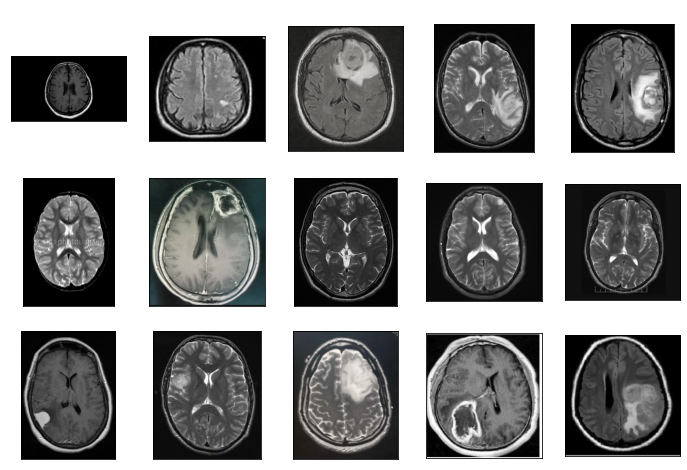

In [16]:
#visualize brain tumor images

plt.figure(figsize=(12,8))
for i in range(15):
    random = np.random.randint(1,len(df))
    plt.subplot(3,5,i+1)
    plt.imshow(cv2.imread(df.loc[random,"filepaths"]))
    plt.title(df.loc[random, "labels"], size = 15, color = "white") 
    plt.xticks([])
    plt.yticks([])
    
plt.show()

### Train test split

In [17]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, train_size=0.8, random_state=0)
train_new, valid = train_test_split(train, train_size=0.80, random_state=0)

print(f"train set shape: {train_new.shape}")
print(f"test set shape: {test.shape}")
print(f"validation set shape: {valid.shape}")

train set shape: (161, 2)
test set shape: (51, 2)
validation set shape: (41, 2)


### Data Augmentation

In [18]:
def data_aug(preprocess_wrapper):
    train_datagen = ImageDataGenerator(rescale = 1.0/255.0,rotation_range = 15, width_shift_range = 0.05, height_shift_range = 0.05, 
                                   shear_range = 0.05, horizontal_flip = True, vertical_flip =True,preprocessing_function=preprocess_wrapper)
    test_datagen = ImageDataGenerator(rescale = 1.0/255.0 , preprocessing_function=preprocess_wrapper)
    
    RANDOM_SEED = 1234
    
    train_gen = train_datagen.flow_from_dataframe(dataframe = train_new,
                                            x_col = 'filepaths', y_col ='labels',
                                            target_size = (150,150), batch_size = 16, 
                                            class_mode = 'binary', shuffle = True,seed=RANDOM_SEED)
    val_gen = train_datagen.flow_from_dataframe(valid, 
                                            target_size=(150,150), x_col = 'filepaths', y_col ='labels', 
                                            class_mode='binary',
                                            batch_size= 16, shuffle=True,seed=RANDOM_SEED)
    test_gen = test_datagen.flow_from_dataframe(test,
                                            target_size = (150,150), x_col = 'filepaths', y_col ='labels',
                                             class_mode = 'binary',
                                            batch_size = 16, shuffle = False,seed=RANDOM_SEED)
    
    return [train_gen,val_gen,test_gen]

### CNN Model

In [19]:
def imgnet_model(train_gen,val_gen,model_name):
    base_model = tf.keras.applications.InceptionResNetV2(weights='imagenet', input_shape = (200,200,3),include_top=False)
    
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(128, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(1, activation = 'sigmoid'))
    model.summary()
    
    callbacks = [
    tf.keras.callbacks.ModelCheckpoint(model_name, save_best_only=True, verbose = 0),
    tf.keras.callbacks.EarlyStopping(patience=6, monitor='val_accuracy', mode='max',verbose=1)]

    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate = 0.0001), metrics=['accuracy'])

    history = model.fit(train_gen, validation_data = val_gen, epochs = 40, callbacks = [callbacks], verbose = 1)
    
    return [model,history]   

In [20]:
def model_performance(history):
    # plot model performance
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(history.epoch) + 1)

    plt.figure(figsize=(15,5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Set')
    plt.plot(epochs_range, val_acc, label='Val Set')
    plt.legend(loc="best")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Set')
    plt.plot(epochs_range, val_loss, label='Val Set')
    plt.legend(loc="best")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Model Loss')

    plt.tight_layout()
    plt.show()

In [21]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,ConfusionMatrixDisplay

def model_report(model,test_gen):
    predictions = model.predict(test_gen)
    predictions = [1 if x>0.5 else 0 for x in predictions]
    

    accuracy = accuracy_score(test_gen.classes, predictions)
    print('Val Accuracy = ' , accuracy)

    print(classification_report(test_gen.classes, predictions))
    
    cm = confusion_matrix(test_gen.classes, predictions) 
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

### Models

#### 1) no pre-process

In [27]:
processes1 = []

In [28]:
def preprocess_wrapper1(img):
    return preprocess_pipeline(processes1,img)

In [29]:
train_gen1,val_gen1,test_gen1 = data_aug(preprocess_wrapper1)
model1,history1 = imgnet_model(train_gen1,val_gen1,'model/model1.h5')

Found 161 validated image filenames belonging to 2 classes.
Found 41 validated image filenames belonging to 2 classes.
Found 51 validated image filenames belonging to 2 classes.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 4, 4, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1536)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               196736    
_________________________________________________________________
batch_normalization_407 (Bat (None, 128)               512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 

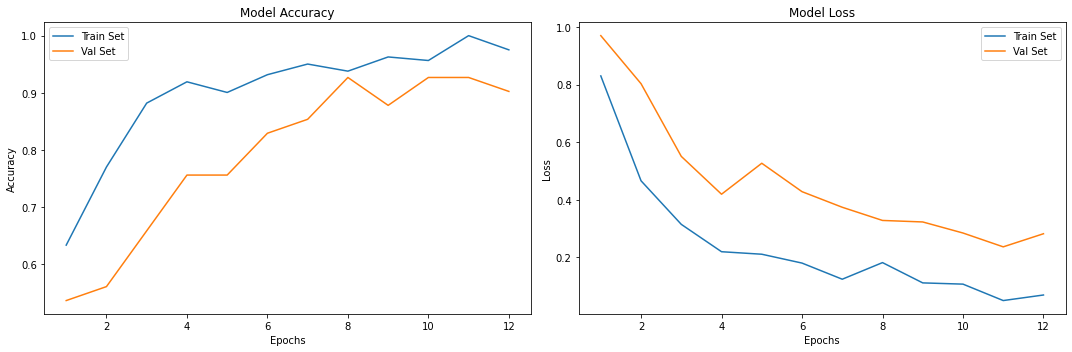

In [30]:
model_performance(history1)

Val Accuracy =  0.9411764705882353
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        15
           1       1.00      0.92      0.96        36

    accuracy                           0.94        51
   macro avg       0.92      0.96      0.93        51
weighted avg       0.95      0.94      0.94        51



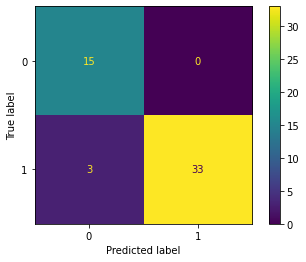

In [31]:
model_report(model1,test_gen1)

#### 2) histogram equalization

In [26]:
processes2 = ['histogram equalization']

In [27]:
def preprocess_wrapper2(img):
    return preprocess_pipeline(processes2,img)

In [28]:
train_gen2,val_gen2,test_gen2 = data_aug(preprocess_wrapper2)
model2,history2 = imgnet_model(train_gen2,val_gen2,'model/model2.h5')

Found 161 validated image filenames belonging to 2 classes.
Found 41 validated image filenames belonging to 2 classes.
Found 51 validated image filenames belonging to 2 classes.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 4, 4, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1536)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               196736    
_________________________________________________________________
batch_normalization_407 (Bat (None, 128)               512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 

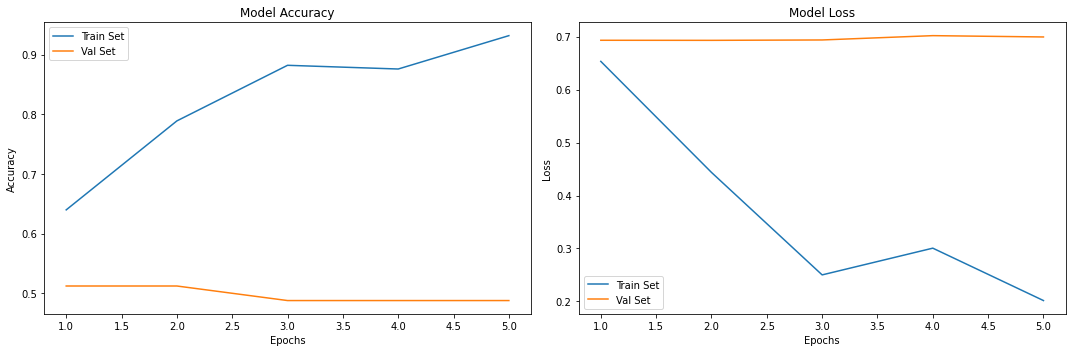

In [29]:
model_performance(history2)

Val Accuracy =  0.29411764705882354
              precision    recall  f1-score   support

           0       0.29      1.00      0.45        15
           1       0.00      0.00      0.00        36

    accuracy                           0.29        51
   macro avg       0.15      0.50      0.23        51
weighted avg       0.09      0.29      0.13        51



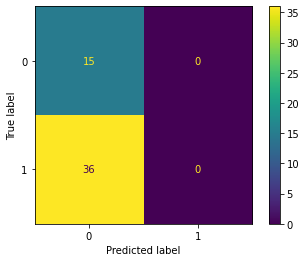

In [30]:
model_report(model2,test_gen2)

#### 3) clahe

In [44]:
processes3 = ['clahe']

In [45]:
def preprocess_wrapper3(img):
    return preprocess_pipeline(processes3,img)

In [46]:
train_gen3,val_gen3,test_gen3 = data_aug(preprocess_wrapper3)
model3,history3 = imgnet_model(train_gen3,val_gen3,'model/model3.h5')

Found 161 validated image filenames belonging to 2 classes.
Found 41 validated image filenames belonging to 2 classes.
Found 51 validated image filenames belonging to 2 classes.
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 4, 4, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1536)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               196736    
_________________________________________________________________
batch_normalization_1019 (Ba (None, 128)               512       
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 

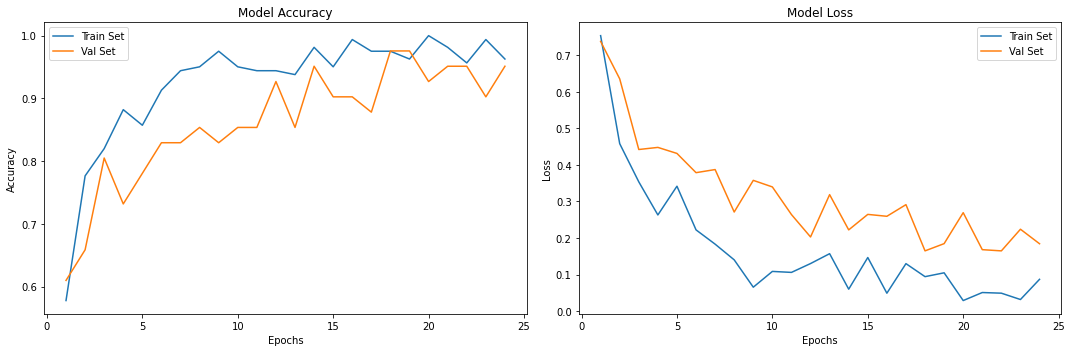

In [47]:
model_performance(history3)

Val Accuracy =  0.8823529411764706
              precision    recall  f1-score   support

           0       0.74      0.93      0.82        15
           1       0.97      0.86      0.91        36

    accuracy                           0.88        51
   macro avg       0.85      0.90      0.87        51
weighted avg       0.90      0.88      0.89        51



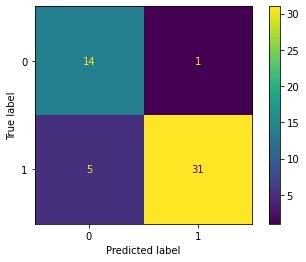

In [48]:
model_report(model3,test_gen3)

#### 4) median filter

In [21]:
processes4 = ['median filter']

In [22]:
def preprocess_wrapper4(img):
    return preprocess_pipeline(processes4,img)

In [23]:
train_gen4,val_gen4,test_gen4 = data_aug(preprocess_wrapper4)
model4,history4 = imgnet_model(train_gen4,val_gen4,'model/model4.h5')

Found 161 validated image filenames belonging to 2 classes.
Found 41 validated image filenames belonging to 2 classes.
Found 51 validated image filenames belonging to 2 classes.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 4, 4, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               196736    
_________________________________________________________________
batch_normalization_203 (Bat (None, 128)               512       
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (D

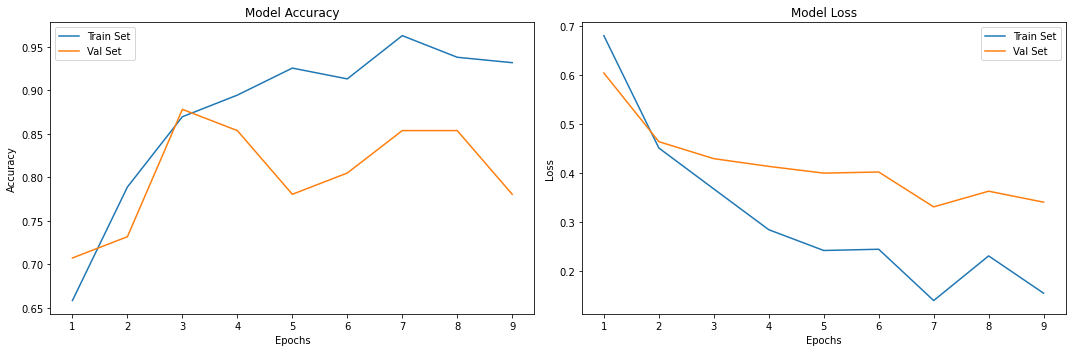

In [24]:
model_performance(history4)

Val Accuracy =  0.9215686274509803
              precision    recall  f1-score   support

           0       0.92      0.80      0.86        15
           1       0.92      0.97      0.95        36

    accuracy                           0.92        51
   macro avg       0.92      0.89      0.90        51
weighted avg       0.92      0.92      0.92        51



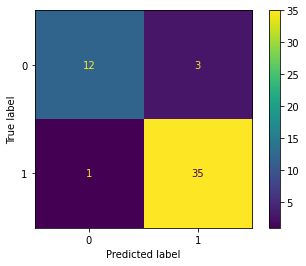

In [25]:
model_report(model4,test_gen4)

#### 5) gaussian filter

In [26]:
processes5 = ['gaussian filter']

In [27]:
def preprocess_wrapper5(img):
    return preprocess_pipeline(processes5,img)

In [28]:
train_gen5,val_gen5,test_gen5 = data_aug(preprocess_wrapper5)
model5,history5 = imgnet_model(train_gen5,val_gen5,'model/model5.h5')

Found 161 validated image filenames belonging to 2 classes.
Found 41 validated image filenames belonging to 2 classes.
Found 51 validated image filenames belonging to 2 classes.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 4, 4, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1536)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               196736    
_________________________________________________________________
batch_normalization_407 (Bat (None, 128)               512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 

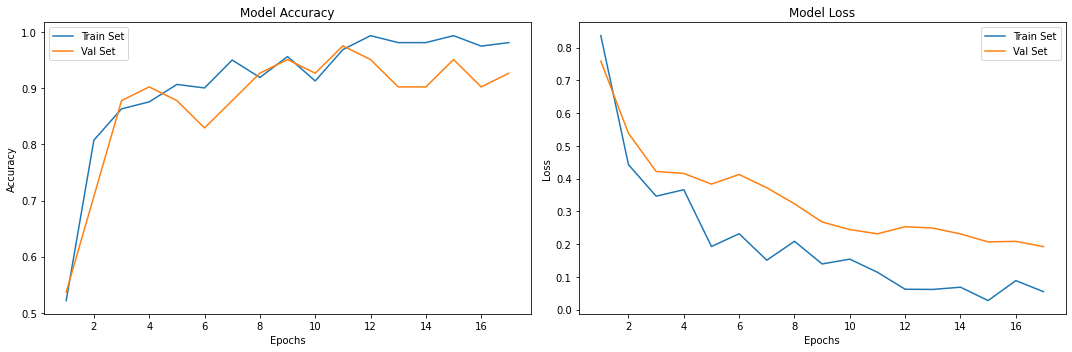

In [29]:
model_performance(history5)

Val Accuracy =  0.9607843137254902
              precision    recall  f1-score   support

           0       0.88      1.00      0.94        15
           1       1.00      0.94      0.97        36

    accuracy                           0.96        51
   macro avg       0.94      0.97      0.95        51
weighted avg       0.97      0.96      0.96        51



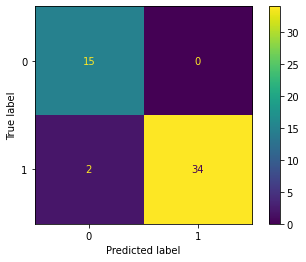

In [30]:
model_report(model5,test_gen5)

#### 6) dilation

In [31]:
processes6 = ['dilation']

In [32]:
def preprocess_wrapper6(img):
    return preprocess_pipeline(processes6,img)

In [33]:
train_gen6,val_gen6,test_gen6 = data_aug(preprocess_wrapper6)
model6,history6 = imgnet_model(train_gen6,val_gen6,'model/model6.h5')

Found 161 validated image filenames belonging to 2 classes.
Found 41 validated image filenames belonging to 2 classes.
Found 51 validated image filenames belonging to 2 classes.
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 4, 4, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1536)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               196736    
_________________________________________________________________
batch_normalization_611 (Bat (None, 128)               512       
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 

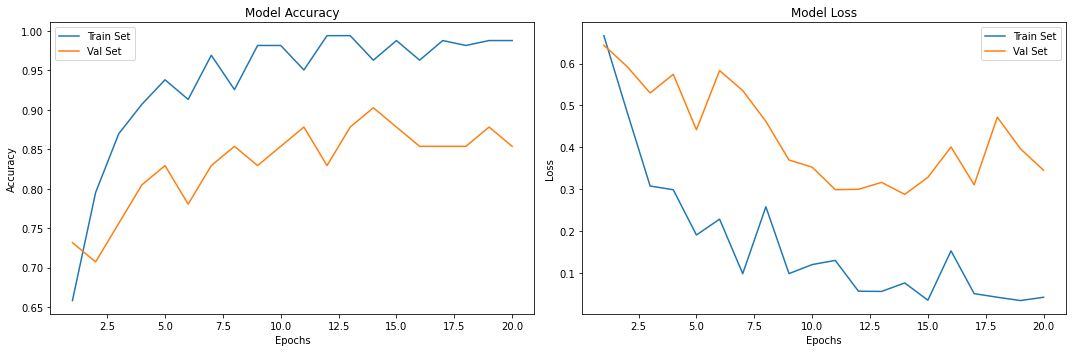

In [34]:
model_performance(history6)

Val Accuracy =  0.9019607843137255
              precision    recall  f1-score   support

           0       0.75      1.00      0.86        15
           1       1.00      0.86      0.93        36

    accuracy                           0.90        51
   macro avg       0.88      0.93      0.89        51
weighted avg       0.93      0.90      0.91        51



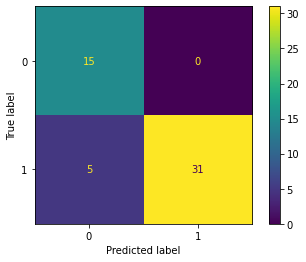

In [35]:
model_report(model6,test_gen6)

#### 7) erosion

In [ ]:
processes7 = ['erosion']

In [ ]:
def preprocess_wrapper7(img):
    return preprocess_pipeline(processes7,img)

In [39]:
train_gen7,val_gen7,test_gen7 = data_aug(preprocess_wrapper7)
model7,history7 = imgnet_model(train_gen7,val_gen7,'model/model7.h5')

Found 161 validated image filenames belonging to 2 classes.
Found 41 validated image filenames belonging to 2 classes.
Found 51 validated image filenames belonging to 2 classes.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 4, 4, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1536)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               196736    
_________________________________________________________________
batch_normalization_407 (Bat (None, 128)               512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 

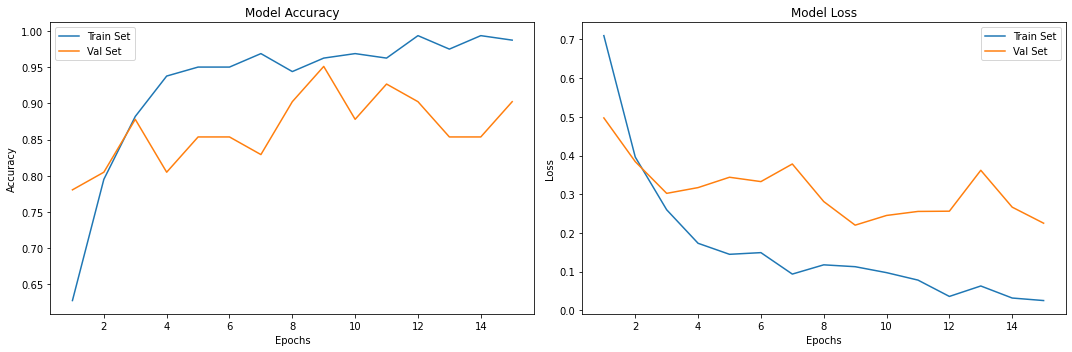

In [40]:
model_performance(history7)

Val Accuracy =  0.9803921568627451
              precision    recall  f1-score   support

           0       1.00      0.93      0.97        15
           1       0.97      1.00      0.99        36

    accuracy                           0.98        51
   macro avg       0.99      0.97      0.98        51
weighted avg       0.98      0.98      0.98        51



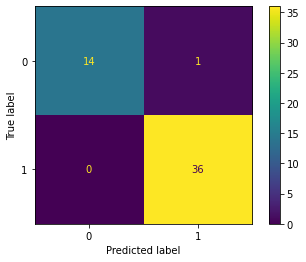

In [41]:
model_report(model7,test_gen7)

#### 8) median filter + clahe

In [26]:
processes8 = ['median filter','clahe']

In [27]:
def preprocess_wrapper8(img):
    return preprocess_pipeline(processes8,img)

In [28]:
train_gen8,val_gen8,test_gen8 = data_aug(preprocess_wrapper8)
model8,history8 = imgnet_model(train_gen8,val_gen8,'model/model8.h5')

Found 161 validated image filenames belonging to 2 classes.
Found 41 validated image filenames belonging to 2 classes.
Found 51 validated image filenames belonging to 2 classes.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 4, 4, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1536)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               196736    
_________________________________________________________________
batch_normalization_407 (Bat (None, 128)               512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 

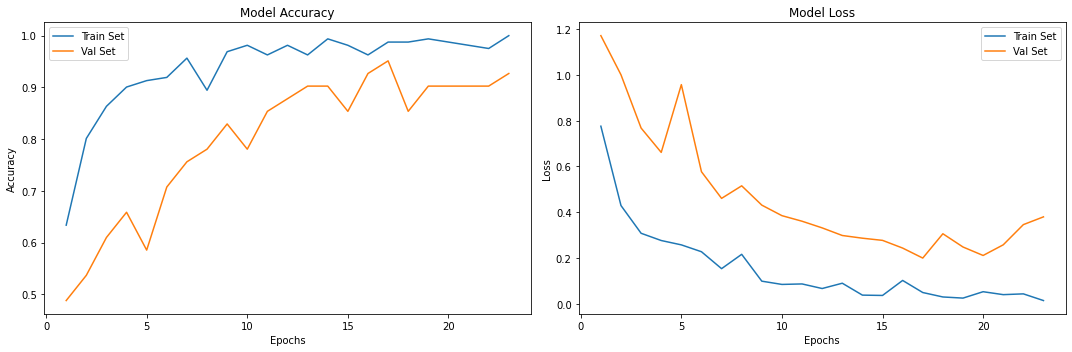

In [29]:
model_performance(history8)

Val Accuracy =  0.9411764705882353
              precision    recall  f1-score   support

           0       0.88      0.93      0.90        15
           1       0.97      0.94      0.96        36

    accuracy                           0.94        51
   macro avg       0.92      0.94      0.93        51
weighted avg       0.94      0.94      0.94        51



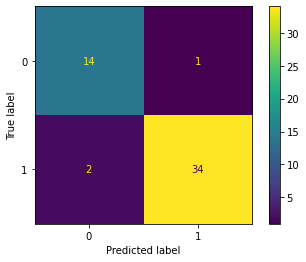

In [30]:
model_report(model8,test_gen8)

#### 9) erosion + clahe

In [21]:
processes9 = ['erosion','clahe']

In [22]:
def preprocess_wrapper9(img):
    return preprocess_pipeline(processes9,img)

In [23]:
train_gen9,val_gen9,test_gen9 = data_aug(preprocess_wrapper9)
model9,history9 = imgnet_model(train_gen9,val_gen9,'model/model9.h5')

Found 161 validated image filenames belonging to 2 classes.
Found 41 validated image filenames belonging to 2 classes.
Found 51 validated image filenames belonging to 2 classes.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 4, 4, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               196736    
_________________________________________________________________
batch_normalization_203 (Bat (None, 128)               512       
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (D

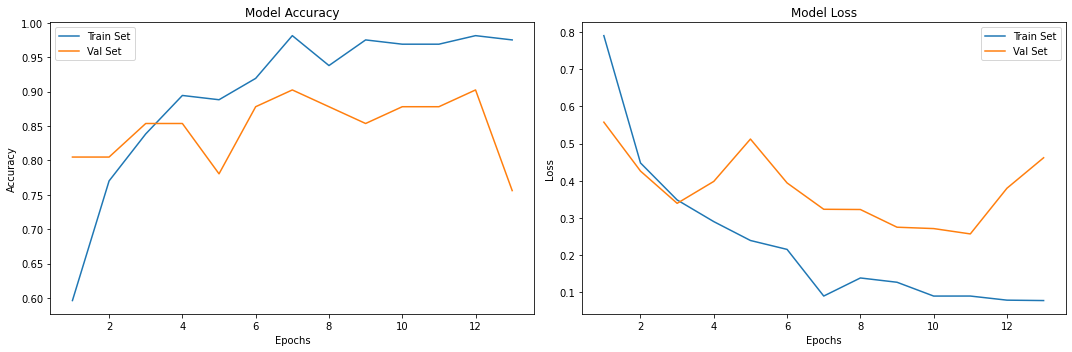

In [24]:
model_performance(history9)

Val Accuracy =  0.803921568627451
              precision    recall  f1-score   support

           0       0.60      1.00      0.75        15
           1       1.00      0.72      0.84        36

    accuracy                           0.80        51
   macro avg       0.80      0.86      0.79        51
weighted avg       0.88      0.80      0.81        51



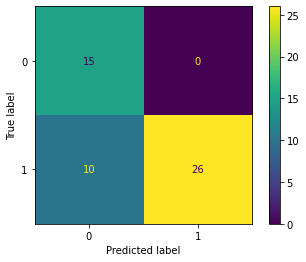

In [25]:
model_report(model9,test_gen9)

#### cropped images

In [52]:
processes10 = ['crop']

In [54]:
def preprocess_wrapper10(img):
    return preprocess_pipeline(processes10,img)

In [59]:
train_gen10,val_gen10,test_gen10 = data_aug(preprocess_wrapper10)
model10,history10 = imgnet_model(train_gen10,val_gen10,'model/model10.h5')

Found 161 validated image filenames belonging to 2 classes.
Found 41 validated image filenames belonging to 2 classes.
Found 51 validated image filenames belonging to 2 classes.
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 4, 4, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_6 ( (None, 1536)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               196736    
_________________________________________________________________
batch_normalization_1427 (Ba (None, 128)               512       
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_13

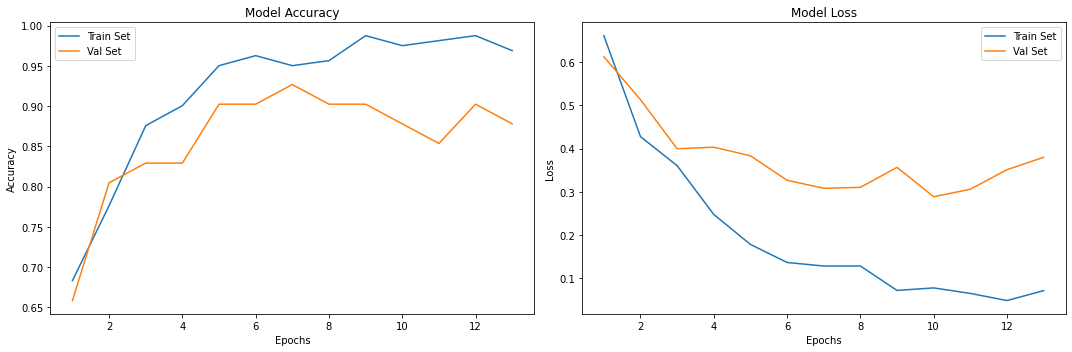

In [60]:
model_performance(history10)

Val Accuracy =  0.9019607843137255
              precision    recall  f1-score   support

           0       0.75      1.00      0.86        15
           1       1.00      0.86      0.93        36

    accuracy                           0.90        51
   macro avg       0.88      0.93      0.89        51
weighted avg       0.93      0.90      0.91        51



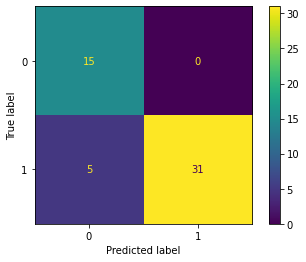

In [61]:
model_report(model10,test_gen10)

#### cropped + median

In [22]:
processes11 = ['crop','median filter']

In [23]:
def preprocess_wrapper11(img):
    return preprocess_pipeline(processes11,img)

In [24]:
train_gen11,val_gen11,test_gen11 = data_aug(preprocess_wrapper11)
model11,history11 = imgnet_model(train_gen11,val_gen11,'model/model11.h5')

Found 161 validated image filenames belonging to 2 classes.
Found 41 validated image filenames belonging to 2 classes.
Found 51 validated image filenames belonging to 2 classes.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 4, 4, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               196736    
_________________________________________________________________
batch_normalization_203 (Bat (None, 128)               512       
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (D

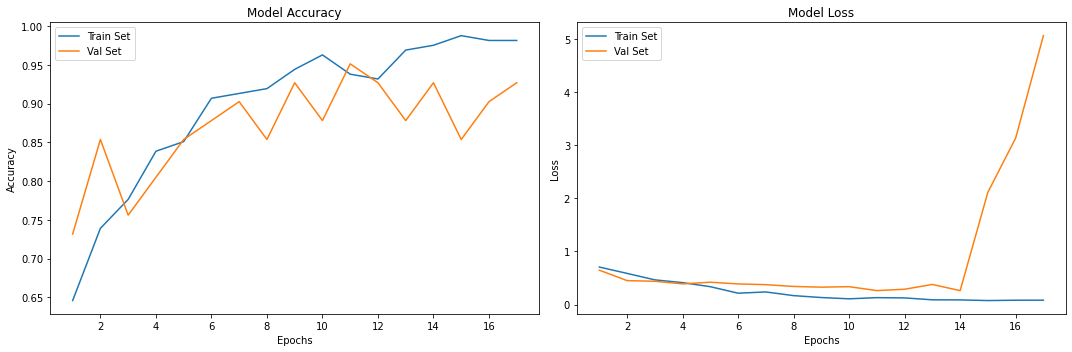

In [25]:
model_performance(history11)

Val Accuracy =  0.9803921568627451
              precision    recall  f1-score   support

           0       1.00      0.93      0.97        15
           1       0.97      1.00      0.99        36

    accuracy                           0.98        51
   macro avg       0.99      0.97      0.98        51
weighted avg       0.98      0.98      0.98        51



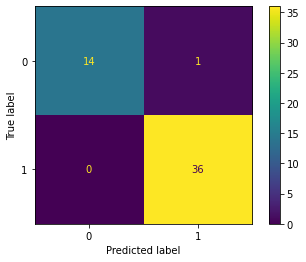

In [26]:
model_report(model11,test_gen11)

#### 12) crop + median + erosion

In [27]:
processes12 = ['crop','median filter','erosion']

In [28]:
def preprocess_wrapper12(img):
    return preprocess_pipeline(processes12,img)

In [29]:
train_gen12,val_gen12,test_gen12 = data_aug(preprocess_wrapper12)
model12,history12 = imgnet_model(train_gen12,val_gen12,'model/model12.h5')

Found 161 validated image filenames belonging to 2 classes.
Found 41 validated image filenames belonging to 2 classes.
Found 51 validated image filenames belonging to 2 classes.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 4, 4, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1536)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               196736    
_________________________________________________________________
batch_normalization_407 (Bat (None, 128)               512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 

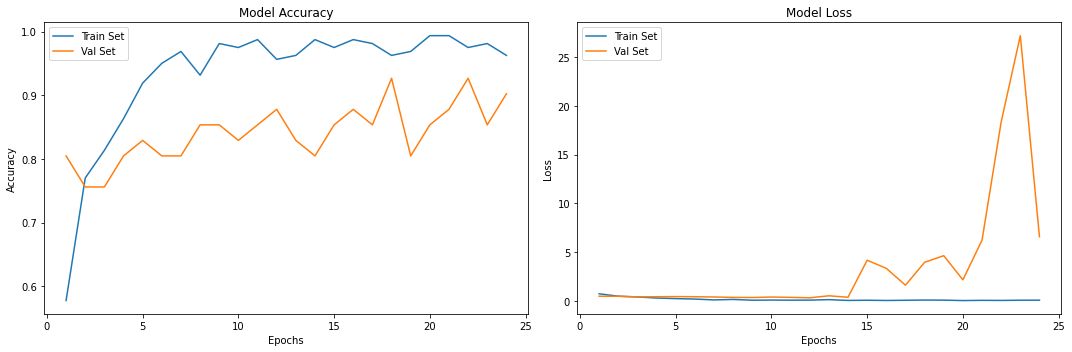

In [30]:
model_performance(history12)

Val Accuracy =  0.9803921568627451
              precision    recall  f1-score   support

           0       1.00      0.93      0.97        15
           1       0.97      1.00      0.99        36

    accuracy                           0.98        51
   macro avg       0.99      0.97      0.98        51
weighted avg       0.98      0.98      0.98        51



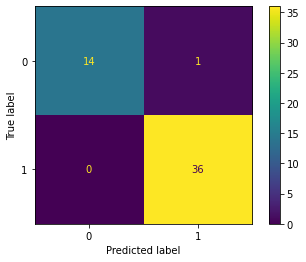

In [31]:
model_report(model11,test_gen12)